In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices("GPU")

[]

In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [ ]:
import gdown

In [ ]:
# url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
#   https://drive.google.com/file/d/1EG1b8pUoLZKLhFf_bpNYLkJle_Srl0PA/view?usp=sharing
# output = "data.zip"
# gdown.download(url, output, quiet=False)
# gdown.extractall("data.zip")

In [ ]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # todo - try dlib to extract the lips
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path: str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != "sil":
            tokens = [*tokens, " ", line[2]]
    return char_to_num(
        tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1))
    )[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split("/")[-1].split(".")[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join("project", "data", "s1", f"{file_name}.mpg")
    alignment_path = os.path.join(
        "project", "data", "alignments", "s1", f"{file_name}.align"
    )
    # print(
    #     f"filename - {file_name } , \nvideopath - {video_path} , \nalignment_path - {alignment_path}."
    # )
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [ ]:
test_path = "project/data/s1/bbaf3s.mpg"

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode("utf-8").split("/")[-1].split(".")[0]

'bbaf3s'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

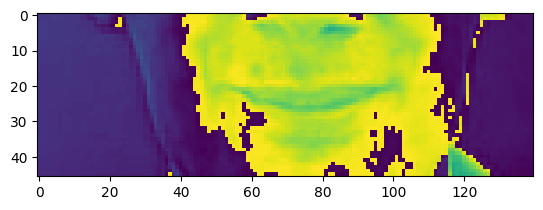

In [ ]:
plt.imshow(frames[4])

In [ ]:
tf.strings.reduce_join(
    [bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]
)

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>

In [ ]:
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Create Data Pipeline


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files("project/data/s1/*.mpg")
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next()

In [ ]:
val[0][0].shape

(75, 46, 140, 1)

In [ ]:
# imageio.mimsave('animation.gif', val[0][0], fps=10)

TypeError: Cannot handle this data type: (1, 1, 1), <f4

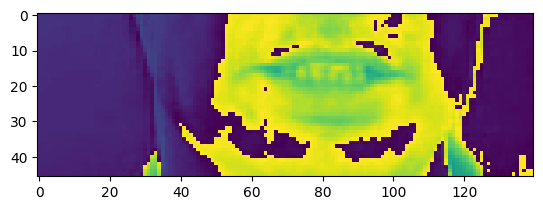

In [ ]:
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in f zero please'>

# Design the Deep Neural Network


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D,
    LSTM,
    Dense,
    Dropout,
    Bidirectional,
    MaxPool3D,
    Activation,
    Reshape,
    SpatialDropout3D,
    BatchNormalization,
    TimeDistributed,
    Flatten,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [70]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [71]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(
    Bidirectional(LSTM(128, kernel_initializer="Orthogonal", return_sequences=True))
)
model.add(Dropout(0.5))

model.add(
    Bidirectional(LSTM(128, kernel_initializer="Orthogonal", return_sequences=True))
)
model.add(Dropout(0.5))

model.add(
    Dense(
        char_to_num.vocabulary_size() + 1,
        kernel_initializer="he_normal",
        activation="softmax",
    )
)

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [73]:
yhat = model.predict(val[0])

2023-12-08 09:29:04.979802: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 494592000 exceeds 10% of free system memory.
2023-12-08 09:29:07.550118: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 247296000 exceeds 10% of free system memory.


1/1 [==============================] - 12s 12s/step


In [74]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa111  '>

In [75]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa111  '>

In [76]:
model.input_shape

(None, 75, 46, 140, 1)

In [77]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train


In [78]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [79]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [80]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][
            0
        ].numpy()
        for x in range(len(yhat)):
            print(
                "Original:",
                tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode("utf-8"),
            )
            print(
                "Prediction:",
                tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode("utf-8"),
            )
            print("~" * 100)

In [81]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [82]:
checkpoint_callback = ModelCheckpoint(
    os.path.join("models", "checkpoint"), monitor="loss", save_weights_only=True
)

In [83]:
schedule_callback = LearningRateScheduler(scheduler)

In [84]:
example_callback = ProduceExample(test)

In [85]:
model.fit(
    train,
    validation_data=test,
    epochs=1,
    callbacks=[checkpoint_callback, schedule_callback, example_callback],
)

2023-12-08 09:29:21.891934: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 494592000 exceeds 10% of free system memory.


: 

: 

In [ ]:
print("jj")

jj
